In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [4]:
df = pd.read_csv(r"C:\Users\mattl\OneDrive\Documents\reibrowser\Database\Redfin Data\geocoded_washington_rentals.csv")

df = df[df["Property Type"] == 6]

In [5]:
features = ["Max Beds", "Max Baths", "Max Square Feet"]
target = "Max Rent Price"


non_seattle_df = df[df["City"] != "Seattle"]
non_seattle_correlation = non_seattle_df[features].corrwith(non_seattle_df[target])

seattle_df = df[df["City"] == "Seattle"]
seattle_correlation = seattle_df[features].corrwith(seattle_df[target])


combined_correlation = pd.DataFrame({
    "Non-Seattle Correlation": non_seattle_correlation,
    "Seattle Correlation": seattle_correlation
})

display(combined_correlation)

,Non-Seattle Correlation,Seattle Correlation
Max Beds,0.575778,0.707475
Max Baths,0.681648,0.400968
Max Square Feet,0.762617,0.859326


In [6]:

# Features and target
features = ["Max Beds", "Max Baths", "Max Square Feet"]
target = "Max Rent Price"

# Add a column to indicate whether each row has missing values
df['Used In Model'] = ~df[features + [target]].isnull().any(axis=1)

# Filter out rows with missing values in features or target
filtered_df = df.dropna(subset=features + [target])

# Prepare the feature matrix (X) and target vector (y)
X = filtered_df[features]
y = filtered_df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the coefficients, mean squared error, and R^2 score
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("Mean squared error:", mse)
print("Mean absolute error: ", mae)
print("R^2 score:", r2)

# Merge predictions back with the initial DataFrame
test_indices = X_test.index
df.loc[test_indices, 'Predicted Max Rent Price'] = y_pred

# Display the DataFrame with the predictions
# display(df)

Coefficients: [-57.96005012 215.57060983   1.36845672]
Intercept: 415.8299010202554
Mean squared error: 997767.8581255852
Mean absolute error:  661.7969732785308
R^2 score: 0.52354044925718


In [7]:
cbg_demographics = pd.read_csv(r"C:\Users\mattl\OneDrive\Documents\reibrowser\Database\Rent Training Data\EPA_SmartLocationDatabase_V3_Jan_2021_Final (1).csv")

cbg_demographics["cbg_geoid"] = \
    cbg_demographics["STATEFP"].astype(str).str.zfill(2)  \
    + cbg_demographics["COUNTYFP"].astype(str).str.zfill(3) \
    + cbg_demographics["TRACTCE"].astype(str).str.zfill(6) \
    + cbg_demographics["BLKGRPCE"].astype(str)

df["cbg_geoid"] = df["cbg_geoid"].astype(str)


df_with_demo = df.merge(cbg_demographics, left_on= "cbg_geoid", right_on="cbg_geoid")

In [8]:
df_with_demo.to_csv(r"C:\Users\mattl\Downloads\df_with_demo.csv")

In [9]:


demographic_features = cbg_demographics.select_dtypes(include = ["number"]).columns
target = "Max Rent Price"

non_seattle_df = df_with_demo[df_with_demo["City"] != "Seattle"]
non_seattle_correlation = non_seattle_df[demographic_features].corrwith(non_seattle_df[target])

seattle_df = df_with_demo[df_with_demo["City"] == "Seattle"]
seattle_correlation = seattle_df[demographic_features].corrwith(seattle_df[target])


combined_correlation = pd.DataFrame({
    "Non-Seattle Correlation": non_seattle_correlation,
    "Seattle Correlation": seattle_correlation
})

display(combined_correlation.sort_values(by="Non-Seattle Correlation", ascending = False))

# display(correlation.sort_values(by="Correlation", ascending = False))

,Non-Seattle Correlation,Seattle Correlation
D5AR,0.398878,-0.040788
CBSA_EMP,0.329722,NaN
CBSA_POP,0.329652,NaN
CBSA_WRK,0.329425,NaN
D5AE,0.299801,-0.065812
...,...,...
Pct_AO1,-0.215340,-0.082981
D3BPO4,-0.235476,0.021040
R_MedWageWk,-0.259508,-0.203132
R_PCTLOWWAGE,-0.386730,-0.255959


In [10]:
# Add Is seattle Filter


df_with_demo["is_seattle"] = df['cbsa_name'].apply(lambda x: 1 if x == "Seattle-Tacoma-Bellevue, WA" else 0)

Adding Demographic Data points boosts performance signifficantly. 
-R2 goes from .52 - .69. Just adding "Is seattle" takes it to Rsquared .82

In [11]:
# Features and target
features = ["Max Beds", "Max Baths", "Max Square Feet", "D5AR", "CBSA_EMP", "CBSA_POP", "CBSA_WRK", "R_PCTLOWWAGE", "is_seattle"]
target = "Max Rent Price"

# Add a column to indicate whether each row has missing values
df_with_demo['Used In Model'] = ~df_with_demo[features + [target]].isnull().any(axis=1)

# Filter out rows with missing values in features or target
filtered_df = df_with_demo.dropna(subset=features + [target])

# Prepare the feature matrix (X) and target vector (y)
X = filtered_df[features]
y = filtered_df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47)

# Initialize and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the coefficients, mean squared error, and R^2 score
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("Mean squared error:", mse)
print("Mean absolute error: ", mae)
print("R^2 score:", r2)

# Merge predictions back with the initial DataFrame
test_indices = X_test.index
df_with_demo.loc[test_indices, 'Predicted Max Rent Price'] = y_pred

# Display the DataFrame with the predictions
# display(df)

Coefficients: [-2.50377050e+01 -5.30363077e+00  1.61432130e+00  1.04734141e-02
 -1.10306947e-03  2.76875039e-03 -4.72962551e-03 -5.30114676e+02
  6.73245949e+02]
Intercept: -654.1220781395527
Mean squared error: 1113336.5256422332
Mean absolute error:  663.5272840356076
R^2 score: 0.8401040861140634


## Test with other types of Regression models 

In [12]:
filtered_df = df_with_demo.dropna(subset=features + [target])

# Prepare the feature matrix (X) and target vector (y)
X = filtered_df[features]
y = filtered_df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47)

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print("Linear Regression")
print("Coefficients:", lr_model.coef_)
print("Intercept:", lr_model.intercept_)
print("Mean squared error:", mse_lr)
print("Mean absolute error:", mae_lr)
print("R^2 score:", r2_lr)
print()

# Ridge Regression
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)
print("Ridge Regression")
print("Coefficients:", ridge_model.coef_)
print("Intercept:", ridge_model.intercept_)
print("Mean squared error:", mse_ridge)
print("Mean absolute error:", mae_ridge)
print("R^2 score:", r2_ridge)
print()

# Lasso Regression
lasso_model = Lasso()
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)
print("Lasso Regression")
print("Coefficients:", lasso_model.coef_)
print("Intercept:", lasso_model.intercept_)
print("Mean squared error:", mse_lasso)
print("Mean absolute error:", mae_lasso)
print("R^2 score:", r2_lasso)
print()

# XGBoost
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print("XGBoost Regression")
print("Mean squared error:", mse_xgb)
print("Mean absolute error:", mae_xgb)
print("R^2 score:", r2_xgb)
print()

Linear Regression
Coefficients: [-2.50377050e+01 -5.30363077e+00  1.61432130e+00  1.04734141e-02
 -1.10306947e-03  2.76875039e-03 -4.72962551e-03 -5.30114676e+02
  6.73245949e+02]
Intercept: -654.1220781395527
Mean squared error: 1113336.5256422332
Mean absolute error: 663.5272840356076
R^2 score: 0.8401040861140634

Ridge Regression
Coefficients: [-2.29158499e+01 -2.10535276e+00  1.61558858e+00  1.05662454e-02
 -1.13326112e-03  2.78886682e-03 -4.73190790e-03 -1.09531538e+02
  3.39868322e+02]
Intercept: -429.86545791091294
Mean squared error: 1107541.2619728404
Mean absolute error: 663.8421061749478
R^2 score: 0.8409363941891919

Lasso Regression
Coefficients: [-1.89520749e+01  2.10368494e+00  1.60889269e+00  1.05910226e-02
 -3.67676711e-04  3.61219478e-04 -4.68545547e-04 -0.00000000e+00
  4.47329894e+02]
Intercept: -452.4872113824563
Mean squared error: 1107958.7979632998
Mean absolute error: 663.3933569689575
R^2 score: 0.8408764282245109

XGBoost Regression
Mean squared error: 19244

c:\Users\mattl\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.433e+08, tolerance: 9.565e+04
  model = cd_fast.enet_coordinate_descent(


In [54]:
median_income = pd.read_csv(r"C:\Users\mattl\OneDrive\Documents\reibrowser\Database\Rent Training Data\ACSDT5Y2022.B19013-Data.csv", skiprows=[1], na_values='-')

# Ensure the GEO_ID column is treated as string
median_income['GEO_ID'] = median_income['GEO_ID'].astype(str)

# Extracting everything after "US" and storing it in a new column 'cbg_geoid'
median_income['cbg_geoid'] = median_income['GEO_ID'].str.extract('US(\d+)')

df['cbg_geoid'] = df['cbg_geoid'].astype(str)

# Joining df with median_income on the 'cbg_geoid' column
df_with_income = df.join(median_income.set_index('cbg_geoid'), on='cbg_geoid', how='inner')



# display(df_with_income)
# Display the resulting DataFrame
features = ["B19013_001E"]
target = "Max Rent Price"


# display(df_with_income)

correlation = df_with_income["Max Rent Price"].corr(df_with_income["B19013_001E"])

print(correlation)

non_seattle_df = df_with_income[df_with_income["City"] != "Seattle"]
non_seattle_correlation = non_seattle_df[features].corrwith(non_seattle_df[target])

seattle_df = df_with_income[df_with_income["City"] == "Seattle"]
seattle_correlation = seattle_df[features].corrwith(seattle_df[target])


combined_correlation = pd.DataFrame({
    "Non-Seattle Correlation": non_seattle_correlation,
    "Seattle Correlation": seattle_correlation
})

display(combined_correlation)

0.539263166780118


,Non-Seattle Correlation,Seattle Correlation
B19013_001E,0.574945,0.274106


### Add Median Income to existing Model

In [59]:
df_with_demo_income = df_with_demo.join(median_income.set_index('cbg_geoid'), on='cbg_geoid', how='inner')

df_with_demo_income['B19013_001E'] = df_with_demo_income['B19013_001E'].str.replace(',', '')
df_with_demo_income['B19013_001E'] = df_with_demo_income['B19013_001E'].str.replace('+', '')
df_with_demo_income['B19013_001E'] = pd.to_numeric(df_with_demo_income['B19013_001E'], errors='coerce')

df_with_demo_income.dtypes

Property ID        int64
URL               object
Property Type      int64
Address           object
City              object
                  ...   
GEO_ID            object
NAME              object
B19013_001E      float64
B19013_001M       object
Unnamed: 4       float64
Length: 146, dtype: object

In [93]:
# Features and target
features = ["Max Beds", "Max Baths", "Max Square Feet", "D5AR", "CBSA_EMP", "CBSA_POP", "CBSA_WRK", "R_PCTLOWWAGE", "is_seattle", "B19013_001E"]
target = "Max Rent Price"

# Add a column to indicate whether each row has missing values
df_with_demo_income['Used In Model'] = ~df_with_demo_income[features + [target]].isnull().any(axis=1)

# Filter out rows with missing values in features or target
filtered_df = df_with_demo_income.dropna(subset=features + [target])

# Prepare the feature matrix (X) and target vector (y)
X = filtered_df[features]
y = filtered_df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47)

# Initialize and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the coefficients, mean squared error, and R^2 score
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("Mean squared error:", mse)
print("Mean absolute error: ", mae)
print("R^2 score:", r2)

# Merge predictions back with the initial DataFrame
test_indices = X_test.index
df_with_demo_income.loc[test_indices, 'Predicted Max Rent Price'] = y_pred

# Display the DataFrame with the predictions
# display(df)

Coefficients: [-5.84472868e+00  1.94369883e+01  1.51808218e+00  9.84832353e-03
  6.57480537e-03  6.25441316e-03 -2.02400856e-02  1.24349422e+03
  0.00000000e+00  2.81783559e-03]
Intercept: -621.3984151583127
Mean squared error: 985375.0190227979
Mean absolute error:  652.5704858617067
R^2 score: 0.8492345731428304


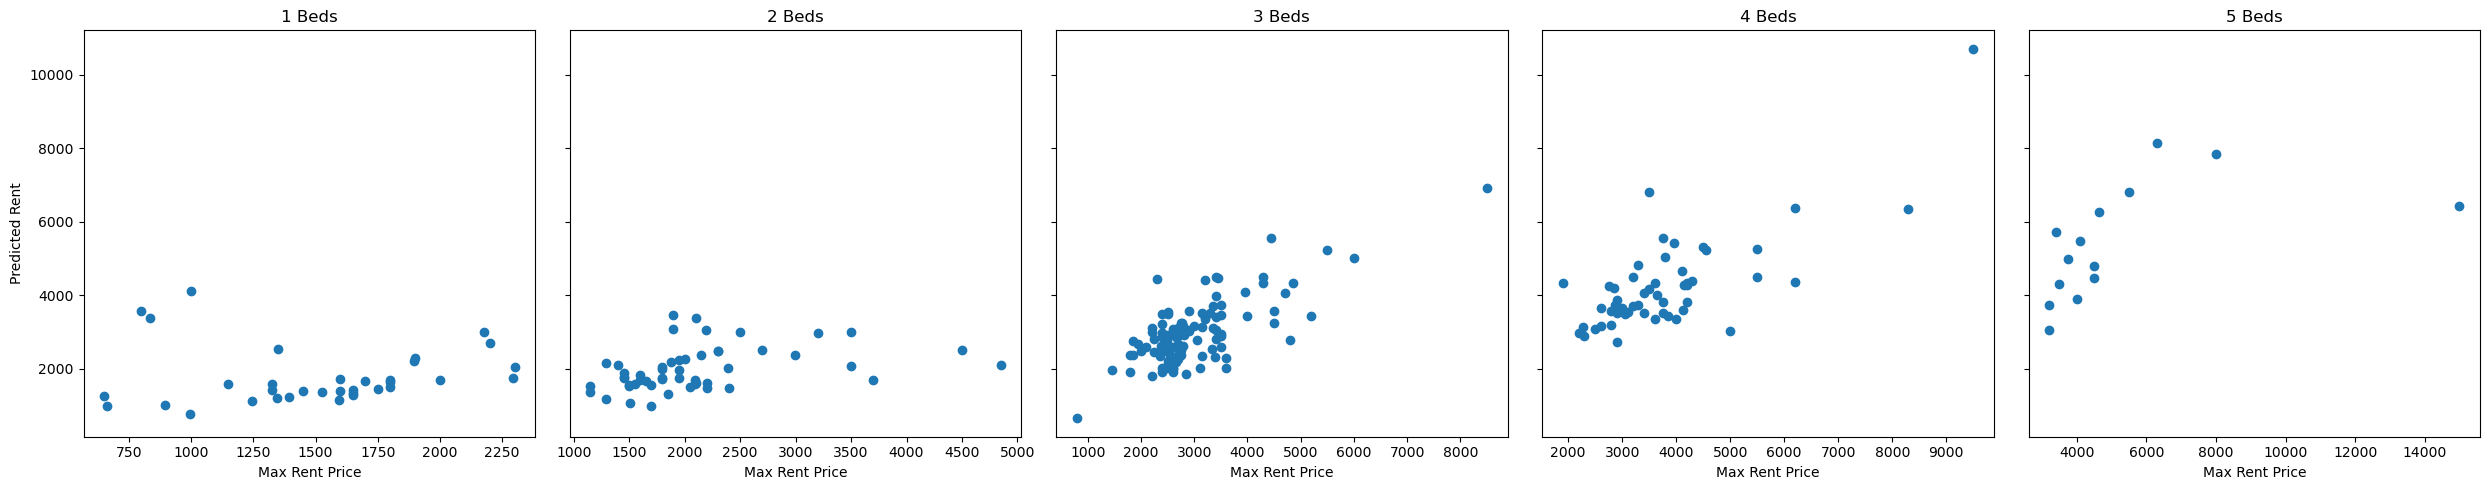

In [91]:
bed_counts = [1, 2, 3,4, 5]

# Set up the subplot grid
fig, axes = plt.subplots(nrows=1, ncols=len(bed_counts), figsize=(25, 5), sharey=True)

for ax, beds in zip(axes, bed_counts):
    subset = df_with_demo_income[df_with_demo_income["Max Beds"] == beds]
    ax.scatter(subset["Max Rent Price"], subset["Predicted Max Rent Price"])
    ax.set_title(f'{beds} Beds')
    ax.set_xlabel("Max Rent Price")
    if ax == axes[0]:  # Only add y label to the first subplot to avoid repetition
        ax.set_ylabel("Predicted Rent")

plt.tight_layout()
plt.show()

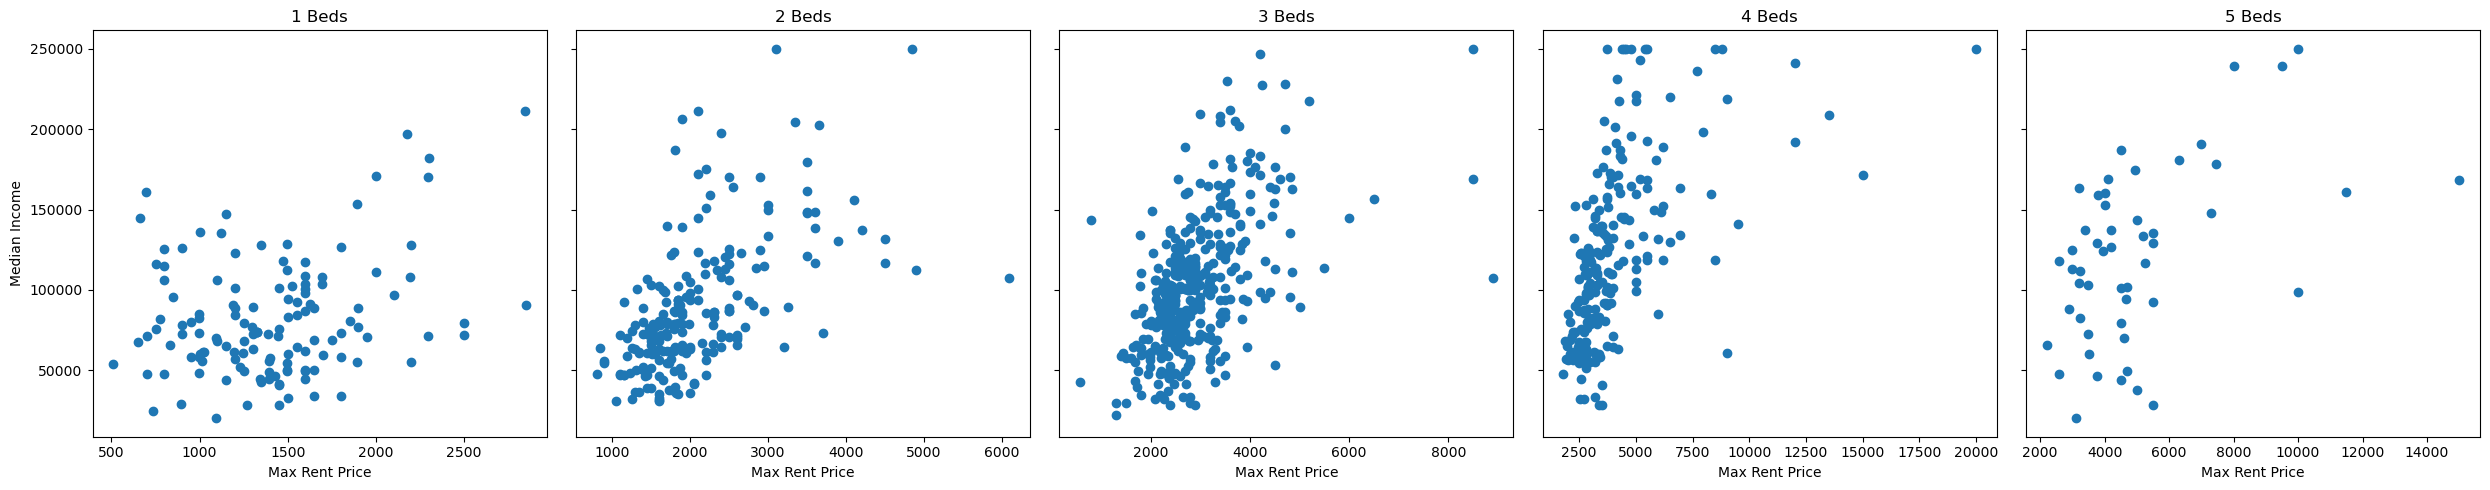

In [77]:
import matplotlib.pyplot as plt

# Define the bed counts you want to plot
bed_counts = [1, 2, 3,4, 5]

# Set up the subplot grid
fig, axes = plt.subplots(nrows=1, ncols=len(bed_counts), figsize=(25, 5), sharey=True)

for ax, beds in zip(axes, bed_counts):
    subset = df_with_demo_income[df_with_demo_income["Max Beds"] == beds]
    ax.scatter(subset["Max Rent Price"], subset["B19013_001E"])
    ax.set_title(f'{beds} Beds')
    ax.set_xlabel("Max Rent Price")
    if ax == axes[0]:  # Only add y label to the first subplot to avoid repetition
        ax.set_ylabel("Median Income")

plt.tight_layout()
plt.show()


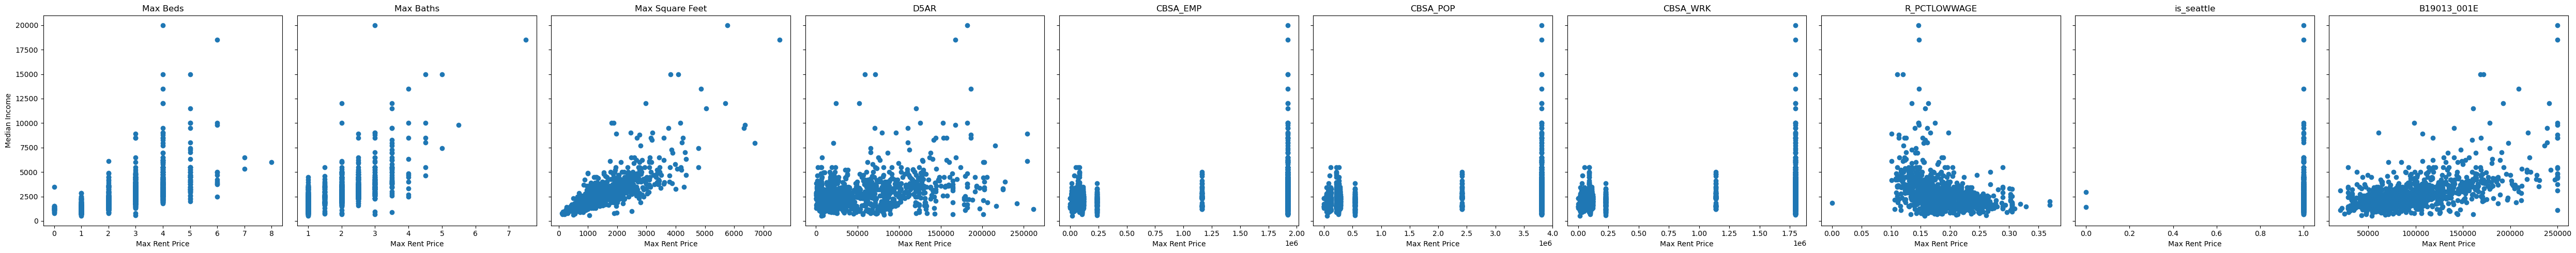

In [88]:
fig, axes = plt.subplots(nrows=1, ncols=len(features), figsize=(50, 5), sharey=True)

for ax, feature in zip(axes, features):
    ax.scatter(df_with_demo_income[feature], df_with_demo_income["Max Rent Price"])
    ax.set_title(f'{feature}')
    ax.set_xlabel("Max Rent Price")
    if ax == axes[0]:  # Only add y label to the first subplot to avoid repetition
        ax.set_ylabel("Median Income")

plt.tight_layout()
plt.show()

In [103]:
# Try Standardizeing the data

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Features and target
features = ["Max Beds", "Max Baths", "Max Square Feet", "D5AR", "CBSA_EMP", "CBSA_POP", "CBSA_WRK", "R_PCTLOWWAGE", "is_seattle", "B19013_001E"]
target = "Max Rent Price"

# Add a column to indicate whether each row has missing values
df_with_demo_income['Used In Model'] = ~df_with_demo_income[features + [target]].isnull().any(axis=1)

# Filter out rows with missing values in features or target
filtered_df = df_with_demo_income.dropna(subset=features + [target])

# filtered_df = filtered_df[filtered_df["City"] == 'Seattle']

# Prepare the feature matrix (X) and target vector (y)
X = filtered_df[features]
y = filtered_df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47)

# Create a pipeline that includes scaling and linear regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regression', LinearRegression())
])

# Fit the model on the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test data
y_pred = pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the coefficients, mean squared error, and R^2 score
print("Coefficients:", pipeline.named_steps['regression'].coef_)
print("Intercept:", pipeline.named_steps['regression'].intercept_)
print("Mean squared error:", mse)
print("Mean absolute error: ", mae)
print("R^2 score:", r2)

# Merge predictions back with the initial DataFrame
test_indices = X_test.index
df_with_demo_income.loc[test_indices, 'Predicted Max Rent Price'] = y_pred

# Optionally, display the DataFrame with the predictions
# display(df_with_demo_income.loc[test_indices])



Coefficients: [-6.80104640e+00  1.70142138e+01  1.52488594e+03  6.13625804e+02
  5.75031744e+03  1.06413177e+04 -1.64385658e+04  5.47679454e+01
  0.00000000e+00  1.44212877e+02]
Intercept: 3185.3304721030036
Mean squared error: 985375.0190231189
Mean absolute error:  652.5704858632025
R^2 score: 0.8492345731427812


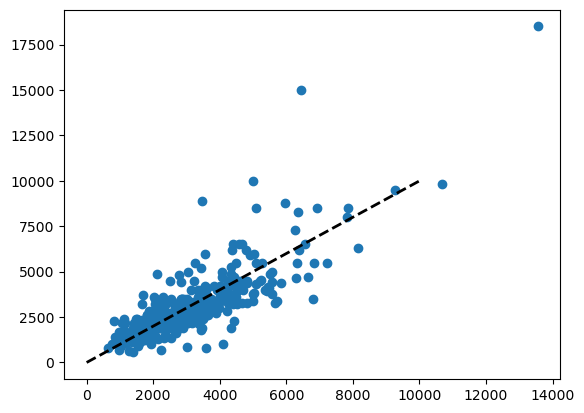

In [117]:
plt.scatter(df_with_demo_income["Predicted Max Rent Price"], df_with_demo_income["Max Rent Price"])

plt.plot([0, 10000], [0, 10000], 'k--', lw=2, label='y = x (Perfect Fit)')
